In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

# A. Generate Data

In [2]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [3]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [4]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [5]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [32]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [33]:
data_dir = 'data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 100}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

Epoch 1/100: 100%|██████████| 500/500 [00:02<00:00, 227.64it/s]


Epoch [1/100], Running Loss: 0.0296
Train Loss: 0.0271
Test Loss: 0.0280


Epoch 2/100: 100%|██████████| 500/500 [00:02<00:00, 235.67it/s]


Epoch [2/100], Running Loss: 0.0247
Train Loss: 0.0201
Test Loss: 0.0214


Epoch 3/100: 100%|██████████| 500/500 [00:02<00:00, 234.22it/s]


Epoch [3/100], Running Loss: 0.0178
Train Loss: 0.0155
Test Loss: 0.0167


Epoch 4/100: 100%|██████████| 500/500 [00:03<00:00, 138.30it/s]


Epoch [4/100], Running Loss: 0.0158
Train Loss: 0.0147
Test Loss: 0.0159


Epoch 5/100: 100%|██████████| 500/500 [00:02<00:00, 229.86it/s]


Epoch [5/100], Running Loss: 0.0152
Train Loss: 0.0143
Test Loss: 0.0157


Epoch 6/100: 100%|██████████| 500/500 [00:02<00:00, 206.09it/s]


Epoch [6/100], Running Loss: 0.0149
Train Loss: 0.0140
Test Loss: 0.0157


Epoch 7/100: 100%|██████████| 500/500 [00:02<00:00, 209.42it/s]


Epoch [7/100], Running Loss: 0.0146
Train Loss: 0.0136
Test Loss: 0.0156


Epoch 8/100: 100%|██████████| 500/500 [00:02<00:00, 214.69it/s]


Epoch [8/100], Running Loss: 0.0143
Train Loss: 0.0132
Test Loss: 0.0155


Epoch 9/100: 100%|██████████| 500/500 [00:02<00:00, 220.53it/s]


Epoch [9/100], Running Loss: 0.0139
Train Loss: 0.0129
Test Loss: 0.0156


Epoch 10/100: 100%|██████████| 500/500 [00:02<00:00, 214.64it/s]


Epoch [10/100], Running Loss: 0.0136
Train Loss: 0.0127
Test Loss: 0.0157


Epoch 11/100: 100%|██████████| 500/500 [00:02<00:00, 209.65it/s]


Epoch [11/100], Running Loss: 0.0131
Train Loss: 0.0123
Test Loss: 0.0160


Epoch 12/100: 100%|██████████| 500/500 [00:02<00:00, 210.33it/s]


Epoch [12/100], Running Loss: 0.0128
Train Loss: 0.0123
Test Loss: 0.0165


Epoch 13/100: 100%|██████████| 500/500 [00:02<00:00, 216.97it/s]


Epoch [13/100], Running Loss: 0.0126
Train Loss: 0.0115
Test Loss: 0.0164


Epoch 14/100: 100%|██████████| 500/500 [00:02<00:00, 225.14it/s]


Epoch [14/100], Running Loss: 0.0123
Train Loss: 0.0112
Test Loss: 0.0166


Epoch 15/100: 100%|██████████| 500/500 [00:02<00:00, 223.70it/s]


Epoch [15/100], Running Loss: 0.0119
Train Loss: 0.0109
Test Loss: 0.0167


Epoch 16/100: 100%|██████████| 500/500 [00:02<00:00, 230.06it/s]


Epoch [16/100], Running Loss: 0.0116
Train Loss: 0.0107
Test Loss: 0.0170


Epoch 17/100: 100%|██████████| 500/500 [00:02<00:00, 232.36it/s]


Epoch [17/100], Running Loss: 0.0113
Train Loss: 0.0104
Test Loss: 0.0175


Epoch 18/100: 100%|██████████| 500/500 [00:02<00:00, 234.63it/s]


Epoch [18/100], Running Loss: 0.0110
Train Loss: 0.0101
Test Loss: 0.0178


Epoch 19/100: 100%|██████████| 500/500 [00:02<00:00, 222.15it/s]


Epoch [19/100], Running Loss: 0.0108
Train Loss: 0.0098
Test Loss: 0.0178


Epoch 20/100: 100%|██████████| 500/500 [00:02<00:00, 229.73it/s]


Epoch [20/100], Running Loss: 0.0105
Train Loss: 0.0095
Test Loss: 0.0182


Epoch 21/100: 100%|██████████| 500/500 [00:02<00:00, 224.94it/s]


Epoch [21/100], Running Loss: 0.0102
Train Loss: 0.0094
Test Loss: 0.0182


Epoch 22/100: 100%|██████████| 500/500 [00:02<00:00, 231.45it/s]


Epoch [22/100], Running Loss: 0.0100
Train Loss: 0.0091
Test Loss: 0.0185


Epoch 23/100: 100%|██████████| 500/500 [00:02<00:00, 228.82it/s]


Epoch [23/100], Running Loss: 0.0097
Train Loss: 0.0089
Test Loss: 0.0188


Epoch 24/100: 100%|██████████| 500/500 [00:02<00:00, 222.49it/s]


Epoch [24/100], Running Loss: 0.0095
Train Loss: 0.0088
Test Loss: 0.0190


Epoch 25/100: 100%|██████████| 500/500 [00:02<00:00, 222.88it/s]


Epoch [25/100], Running Loss: 0.0093
Train Loss: 0.0083
Test Loss: 0.0192


Epoch 26/100: 100%|██████████| 500/500 [00:02<00:00, 211.44it/s]


Epoch [26/100], Running Loss: 0.0090
Train Loss: 0.0081
Test Loss: 0.0198


Epoch 27/100: 100%|██████████| 500/500 [00:02<00:00, 219.87it/s]


Epoch [27/100], Running Loss: 0.0087
Train Loss: 0.0081
Test Loss: 0.0201


Epoch 28/100: 100%|██████████| 500/500 [00:02<00:00, 228.44it/s]


Epoch [28/100], Running Loss: 0.0086
Train Loss: 0.0077
Test Loss: 0.0201


Epoch 29/100: 100%|██████████| 500/500 [00:02<00:00, 227.08it/s]


Epoch [29/100], Running Loss: 0.0083
Train Loss: 0.0078
Test Loss: 0.0205


Epoch 30/100: 100%|██████████| 500/500 [00:02<00:00, 230.33it/s]


Epoch [30/100], Running Loss: 0.0080
Train Loss: 0.0073
Test Loss: 0.0207


Epoch 31/100: 100%|██████████| 500/500 [00:02<00:00, 232.32it/s]


Epoch [31/100], Running Loss: 0.0079
Train Loss: 0.0071
Test Loss: 0.0207


Epoch 32/100: 100%|██████████| 500/500 [00:02<00:00, 236.92it/s]


Epoch [32/100], Running Loss: 0.0077
Train Loss: 0.0068
Test Loss: 0.0207


Epoch 33/100: 100%|██████████| 500/500 [00:02<00:00, 211.07it/s]


Epoch [33/100], Running Loss: 0.0074
Train Loss: 0.0068
Test Loss: 0.0213


Epoch 34/100: 100%|██████████| 500/500 [00:02<00:00, 229.58it/s]


Epoch [34/100], Running Loss: 0.0072
Train Loss: 0.0066
Test Loss: 0.0223


Epoch 35/100: 100%|██████████| 500/500 [00:02<00:00, 231.04it/s]


Epoch [35/100], Running Loss: 0.0071
Train Loss: 0.0063
Test Loss: 0.0216


Epoch 36/100: 100%|██████████| 500/500 [00:02<00:00, 222.89it/s]


Epoch [36/100], Running Loss: 0.0068
Train Loss: 0.0064
Test Loss: 0.0218


Epoch 37/100: 100%|██████████| 500/500 [00:02<00:00, 230.38it/s]


Epoch [37/100], Running Loss: 0.0067
Train Loss: 0.0059
Test Loss: 0.0224


Epoch 38/100: 100%|██████████| 500/500 [00:02<00:00, 215.74it/s]


Epoch [38/100], Running Loss: 0.0065
Train Loss: 0.0060
Test Loss: 0.0226


Epoch 39/100: 100%|██████████| 500/500 [00:02<00:00, 205.63it/s]


Epoch [39/100], Running Loss: 0.0063
Train Loss: 0.0059
Test Loss: 0.0232


Epoch 40/100: 100%|██████████| 500/500 [00:02<00:00, 208.70it/s]


Epoch [40/100], Running Loss: 0.0062
Train Loss: 0.0057
Test Loss: 0.0232


Epoch 41/100: 100%|██████████| 500/500 [00:02<00:00, 201.80it/s]


Epoch [41/100], Running Loss: 0.0060
Train Loss: 0.0054
Test Loss: 0.0235


Epoch 42/100: 100%|██████████| 500/500 [00:02<00:00, 221.73it/s]


Epoch [42/100], Running Loss: 0.0059
Train Loss: 0.0054
Test Loss: 0.0238


Epoch 43/100: 100%|██████████| 500/500 [00:02<00:00, 226.50it/s]


Epoch [43/100], Running Loss: 0.0057
Train Loss: 0.0052
Test Loss: 0.0236


Epoch 44/100: 100%|██████████| 500/500 [00:02<00:00, 223.70it/s]


Epoch [44/100], Running Loss: 0.0056
Train Loss: 0.0052
Test Loss: 0.0235


Epoch 45/100: 100%|██████████| 500/500 [00:02<00:00, 227.11it/s]


Epoch [45/100], Running Loss: 0.0054
Train Loss: 0.0049
Test Loss: 0.0238


Epoch 46/100: 100%|██████████| 500/500 [00:02<00:00, 223.11it/s]


Epoch [46/100], Running Loss: 0.0053
Train Loss: 0.0049
Test Loss: 0.0240


Epoch 47/100: 100%|██████████| 500/500 [00:02<00:00, 230.92it/s]


Epoch [47/100], Running Loss: 0.0052
Train Loss: 0.0049
Test Loss: 0.0245


Epoch 48/100: 100%|██████████| 500/500 [00:02<00:00, 228.43it/s]


Epoch [48/100], Running Loss: 0.0051
Train Loss: 0.0047
Test Loss: 0.0247


Epoch 49/100: 100%|██████████| 500/500 [00:02<00:00, 220.00it/s]


Epoch [49/100], Running Loss: 0.0051
Train Loss: 0.0046
Test Loss: 0.0243


Epoch 50/100: 100%|██████████| 500/500 [00:02<00:00, 226.29it/s]


Epoch [50/100], Running Loss: 0.0049
Train Loss: 0.0045
Test Loss: 0.0245


Epoch 51/100: 100%|██████████| 500/500 [00:02<00:00, 227.02it/s]


Epoch [51/100], Running Loss: 0.0048
Train Loss: 0.0045
Test Loss: 0.0250


Epoch 52/100: 100%|██████████| 500/500 [00:02<00:00, 232.05it/s]


Epoch [52/100], Running Loss: 0.0048
Train Loss: 0.0043
Test Loss: 0.0255


Epoch 53/100: 100%|██████████| 500/500 [00:02<00:00, 229.19it/s]


Epoch [53/100], Running Loss: 0.0047
Train Loss: 0.0041
Test Loss: 0.0253


Epoch 54/100: 100%|██████████| 500/500 [00:02<00:00, 233.34it/s]


Epoch [54/100], Running Loss: 0.0045
Train Loss: 0.0042
Test Loss: 0.0255


Epoch 55/100: 100%|██████████| 500/500 [00:02<00:00, 227.03it/s]


Epoch [55/100], Running Loss: 0.0045
Train Loss: 0.0041
Test Loss: 0.0253


Epoch 56/100: 100%|██████████| 500/500 [00:02<00:00, 225.15it/s]


Epoch [56/100], Running Loss: 0.0045
Train Loss: 0.0041
Test Loss: 0.0258


Epoch 57/100: 100%|██████████| 500/500 [00:02<00:00, 213.73it/s]


Epoch [57/100], Running Loss: 0.0043
Train Loss: 0.0044
Test Loss: 0.0256


Epoch 58/100: 100%|██████████| 500/500 [00:02<00:00, 223.68it/s]


Epoch [58/100], Running Loss: 0.0043
Train Loss: 0.0042
Test Loss: 0.0253


Epoch 59/100: 100%|██████████| 500/500 [00:02<00:00, 219.48it/s]


Epoch [59/100], Running Loss: 0.0042
Train Loss: 0.0039
Test Loss: 0.0259


Epoch 60/100: 100%|██████████| 500/500 [00:02<00:00, 226.56it/s]


Epoch [60/100], Running Loss: 0.0041
Train Loss: 0.0038
Test Loss: 0.0261


Epoch 61/100: 100%|██████████| 500/500 [00:02<00:00, 222.63it/s]


Epoch [61/100], Running Loss: 0.0041
Train Loss: 0.0037
Test Loss: 0.0260


Epoch 62/100: 100%|██████████| 500/500 [00:02<00:00, 223.58it/s]


Epoch [62/100], Running Loss: 0.0040
Train Loss: 0.0037
Test Loss: 0.0260


Epoch 63/100: 100%|██████████| 500/500 [00:02<00:00, 216.45it/s]


Epoch [63/100], Running Loss: 0.0040
Train Loss: 0.0038
Test Loss: 0.0261


Epoch 64/100: 100%|██████████| 500/500 [00:02<00:00, 234.92it/s]


Epoch [64/100], Running Loss: 0.0040
Train Loss: 0.0037
Test Loss: 0.0270


Epoch 65/100: 100%|██████████| 500/500 [00:02<00:00, 230.17it/s]


Epoch [65/100], Running Loss: 0.0039
Train Loss: 0.0036
Test Loss: 0.0268


Epoch 66/100: 100%|██████████| 500/500 [00:02<00:00, 228.79it/s]


Epoch [66/100], Running Loss: 0.0038
Train Loss: 0.0036
Test Loss: 0.0267


Epoch 67/100: 100%|██████████| 500/500 [00:02<00:00, 204.96it/s]


Epoch [67/100], Running Loss: 0.0038
Train Loss: 0.0035
Test Loss: 0.0268


Epoch 68/100: 100%|██████████| 500/500 [00:02<00:00, 204.50it/s]


Epoch [68/100], Running Loss: 0.0038
Train Loss: 0.0034
Test Loss: 0.0263


Epoch 69/100: 100%|██████████| 500/500 [00:02<00:00, 232.76it/s]


Epoch [69/100], Running Loss: 0.0037
Train Loss: 0.0035
Test Loss: 0.0268


Epoch 70/100: 100%|██████████| 500/500 [00:02<00:00, 233.32it/s]


Epoch [70/100], Running Loss: 0.0036
Train Loss: 0.0035
Test Loss: 0.0272


Epoch 71/100: 100%|██████████| 500/500 [00:02<00:00, 221.57it/s]


Epoch [71/100], Running Loss: 0.0037
Train Loss: 0.0036
Test Loss: 0.0271


Epoch 72/100: 100%|██████████| 500/500 [00:02<00:00, 234.60it/s]


Epoch [72/100], Running Loss: 0.0036
Train Loss: 0.0032
Test Loss: 0.0271


Epoch 73/100: 100%|██████████| 500/500 [00:02<00:00, 230.69it/s]


Epoch [73/100], Running Loss: 0.0035
Train Loss: 0.0033
Test Loss: 0.0270


Epoch 74/100: 100%|██████████| 500/500 [00:02<00:00, 221.41it/s]


Epoch [74/100], Running Loss: 0.0035
Train Loss: 0.0035
Test Loss: 0.0274


Epoch 75/100: 100%|██████████| 500/500 [00:02<00:00, 237.35it/s]


Epoch [75/100], Running Loss: 0.0035
Train Loss: 0.0033
Test Loss: 0.0273


Epoch 76/100: 100%|██████████| 500/500 [00:02<00:00, 237.01it/s]


Epoch [76/100], Running Loss: 0.0033
Train Loss: 0.0033
Test Loss: 0.0274


Epoch 77/100: 100%|██████████| 500/500 [00:02<00:00, 238.97it/s]


Epoch [77/100], Running Loss: 0.0033
Train Loss: 0.0031
Test Loss: 0.0273


Epoch 78/100: 100%|██████████| 500/500 [00:02<00:00, 236.30it/s]


Epoch [78/100], Running Loss: 0.0034
Train Loss: 0.0032
Test Loss: 0.0279


Epoch 79/100: 100%|██████████| 500/500 [00:02<00:00, 236.99it/s]


Epoch [79/100], Running Loss: 0.0034
Train Loss: 0.0031
Test Loss: 0.0275


Epoch 80/100: 100%|██████████| 500/500 [00:02<00:00, 224.51it/s]


Epoch [80/100], Running Loss: 0.0033
Train Loss: 0.0030
Test Loss: 0.0279


Epoch 81/100: 100%|██████████| 500/500 [00:02<00:00, 209.87it/s]


Epoch [81/100], Running Loss: 0.0032
Train Loss: 0.0031
Test Loss: 0.0276


Epoch 82/100: 100%|██████████| 500/500 [00:02<00:00, 225.14it/s]


Epoch [82/100], Running Loss: 0.0032
Train Loss: 0.0030
Test Loss: 0.0278


Epoch 83/100: 100%|██████████| 500/500 [00:02<00:00, 226.79it/s]


Epoch [83/100], Running Loss: 0.0032
Train Loss: 0.0032
Test Loss: 0.0274


Epoch 84/100: 100%|██████████| 500/500 [00:02<00:00, 233.10it/s]


Epoch [84/100], Running Loss: 0.0032
Train Loss: 0.0032
Test Loss: 0.0288


Epoch 85/100: 100%|██████████| 500/500 [00:02<00:00, 228.22it/s]


Epoch [85/100], Running Loss: 0.0032
Train Loss: 0.0030
Test Loss: 0.0280


Epoch 86/100: 100%|██████████| 500/500 [00:02<00:00, 222.22it/s]


Epoch [86/100], Running Loss: 0.0031
Train Loss: 0.0029
Test Loss: 0.0283


Epoch 87/100: 100%|██████████| 500/500 [00:02<00:00, 209.94it/s]


Epoch [87/100], Running Loss: 0.0032
Train Loss: 0.0029
Test Loss: 0.0283


Epoch 88/100: 100%|██████████| 500/500 [00:02<00:00, 224.97it/s]


Epoch [88/100], Running Loss: 0.0030
Train Loss: 0.0029
Test Loss: 0.0279


Epoch 89/100: 100%|██████████| 500/500 [00:02<00:00, 235.67it/s]


Epoch [89/100], Running Loss: 0.0031
Train Loss: 0.0029
Test Loss: 0.0286


Epoch 90/100: 100%|██████████| 500/500 [00:02<00:00, 232.13it/s]


Epoch [90/100], Running Loss: 0.0031
Train Loss: 0.0030
Test Loss: 0.0289


Epoch 91/100: 100%|██████████| 500/500 [00:02<00:00, 226.94it/s]


Epoch [91/100], Running Loss: 0.0030
Train Loss: 0.0029
Test Loss: 0.0281


Epoch 92/100: 100%|██████████| 500/500 [00:02<00:00, 222.21it/s]


Epoch [92/100], Running Loss: 0.0030
Train Loss: 0.0028
Test Loss: 0.0289


Epoch 93/100: 100%|██████████| 500/500 [00:02<00:00, 225.23it/s]


Epoch [93/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0286


Epoch 94/100: 100%|██████████| 500/500 [00:02<00:00, 209.71it/s]


Epoch [94/100], Running Loss: 0.0029
Train Loss: 0.0028
Test Loss: 0.0288


Epoch 95/100: 100%|██████████| 500/500 [00:02<00:00, 231.90it/s]


Epoch [95/100], Running Loss: 0.0029
Train Loss: 0.0029
Test Loss: 0.0291


Epoch 96/100: 100%|██████████| 500/500 [00:02<00:00, 228.63it/s]


Epoch [96/100], Running Loss: 0.0029
Train Loss: 0.0029
Test Loss: 0.0285


Epoch 97/100: 100%|██████████| 500/500 [00:02<00:00, 233.25it/s]


Epoch [97/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0289


Epoch 98/100: 100%|██████████| 500/500 [00:02<00:00, 229.73it/s]


Epoch [98/100], Running Loss: 0.0029
Train Loss: 0.0030
Test Loss: 0.0284


Epoch 99/100: 100%|██████████| 500/500 [00:02<00:00, 232.75it/s]


Epoch [99/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0292


Epoch 100/100: 100%|██████████| 500/500 [00:02<00:00, 232.42it/s]


Epoch [100/100], Running Loss: 0.0029
Train Loss: 0.0026
Test Loss: 0.0288


# Evaluate Model

In [34]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Train Loss: 0.0026
Test Loss: 0.0288


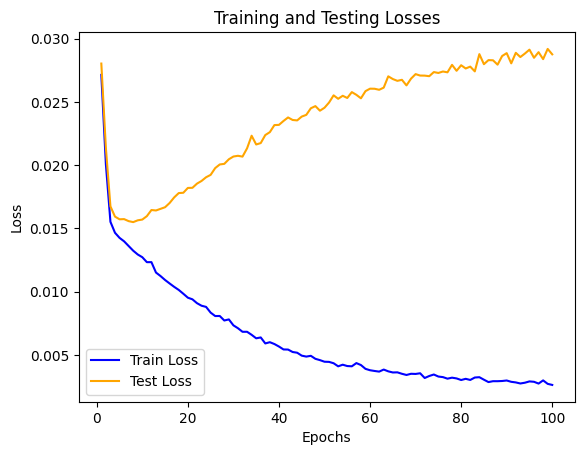

In [36]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## v distribution

### Training Data

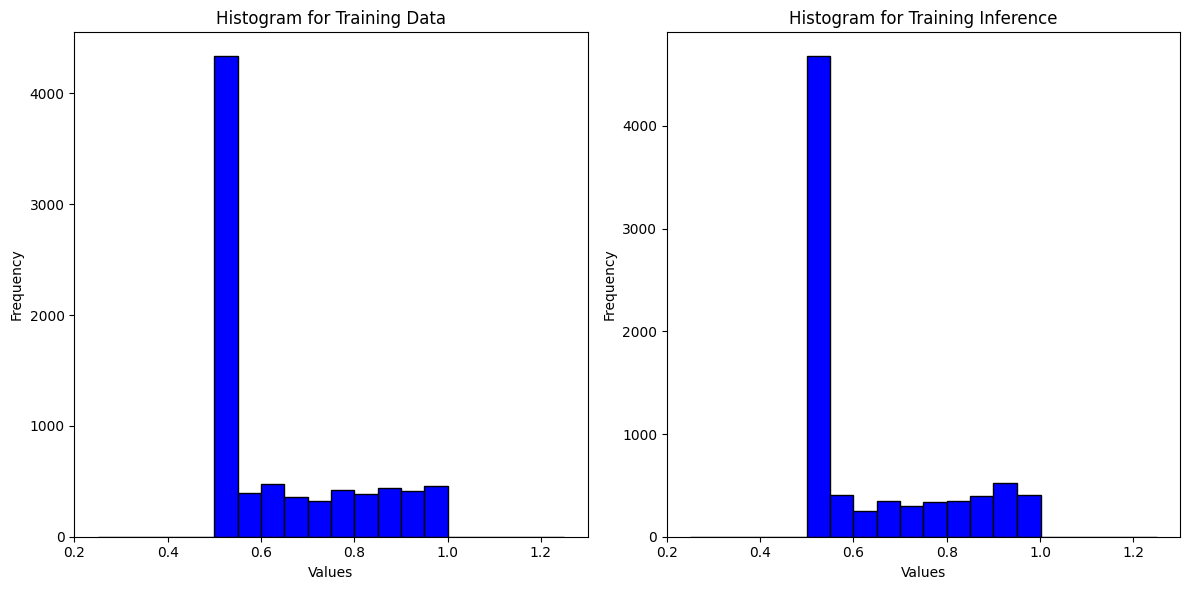

In [50]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for inputs, targets in train_loader:
        train_loader_v += targets.numpy().squeeze().tolist()
        train_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

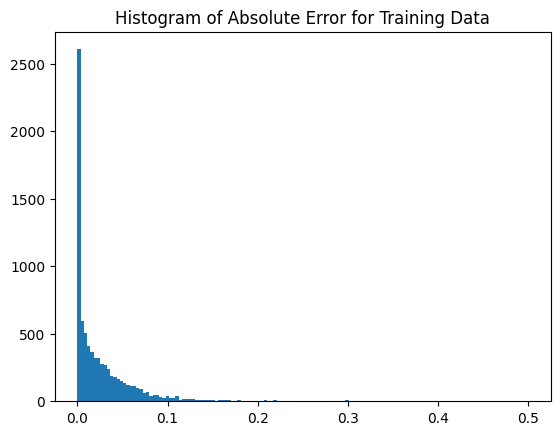

In [38]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

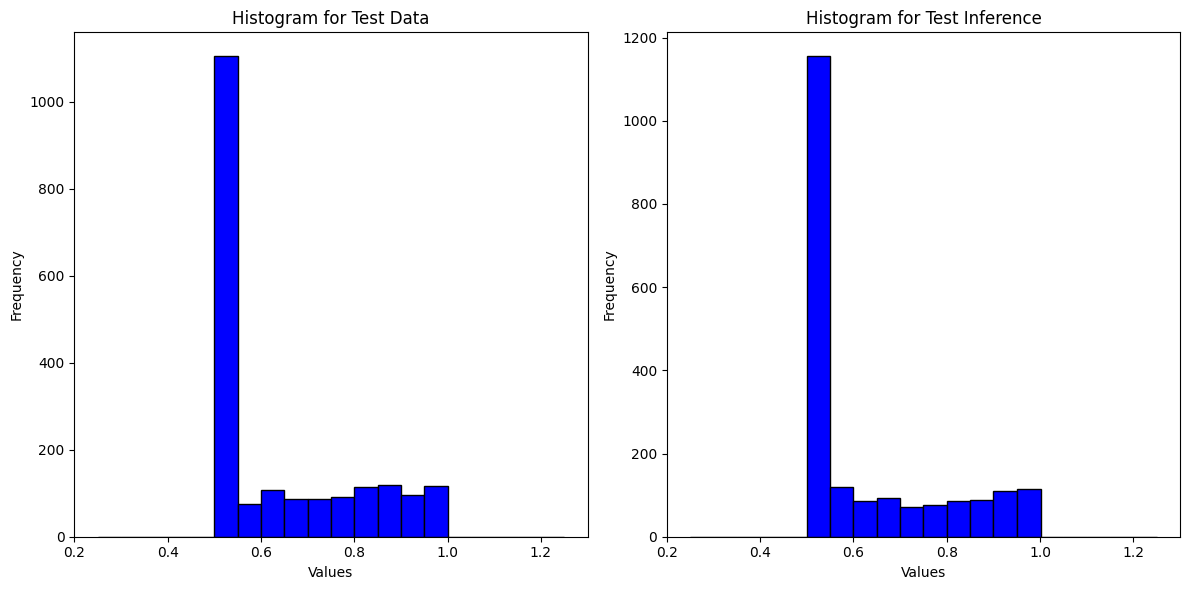

In [39]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for inputs, targets in test_loader:
        test_loader_v += targets.numpy().squeeze().tolist()
        test_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

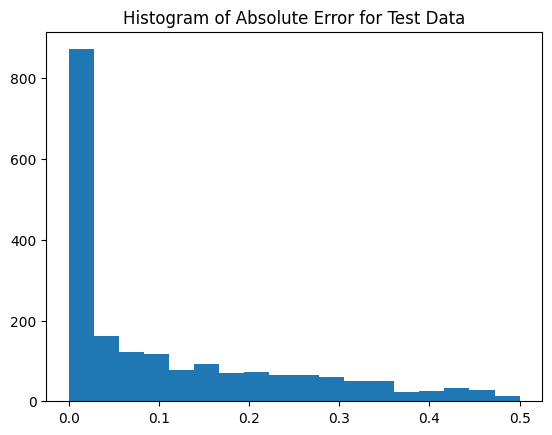

In [40]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [41]:
data_dir = 'data'
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
for phi, true_actives in zip(phi_data, true_actives_data):
    with torch.no_grad():   
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

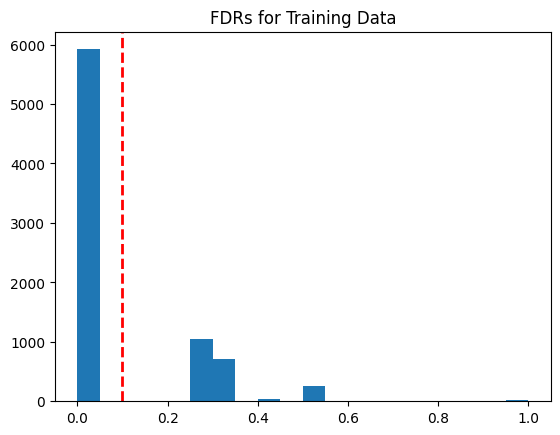

In [42]:
bins = np.arange(0, 1.05, 0.05)
plt.hist(np.array(FDRs)[train_indices], bins=bins)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2)
plt.title("FDRs for Training Data")
plt.show()

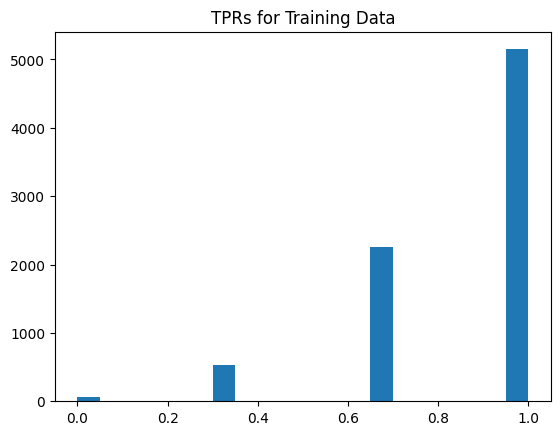

In [43]:
bins = np.arange(0, 1.05, 0.05)
plt.hist(np.array(TPRs)[train_indices], bins=bins)
plt.title("TPRs for Training Data")
plt.show()

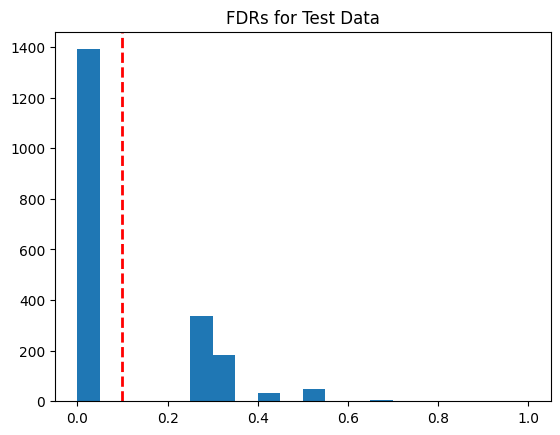

In [46]:
bins = np.arange(0, 1.05, 0.05)
plt.hist(np.array(FDRs)[test_indices], bins=bins)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2)
plt.title("FDRs for Test Data")
plt.show()

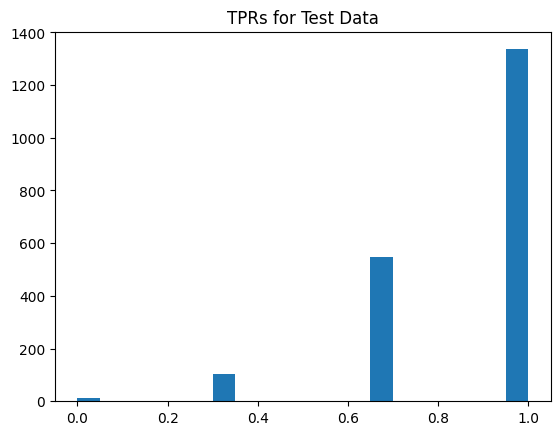

In [47]:
bins = np.arange(0, 1.05, 0.05)
plt.hist(np.array(TPRs)[test_indices], bins=bins)
plt.title("TPRs for Test Data")
plt.show()